In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
device = 'cuda'

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300,300)),
    transforms.RandomCrop((256,256)),
    transforms.RandomRotation((-5,5)),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(r"D:\chest_x_ray\train",
                                                 transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(r"D:\chest_x_ray\test",
                                                transform=img_transform)
val_dataset = torchvision.datasets.ImageFolder(r"D:\chest_x_ray\val",
                                               transform=img_transform)

In [ ]:
len(train_dataset), len(test_dataset), len(val_dataset)

(6326, 771, 38)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=60, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=60, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=60, shuffle=True)

In [ ]:
img, label = next(iter(train_dataloader))

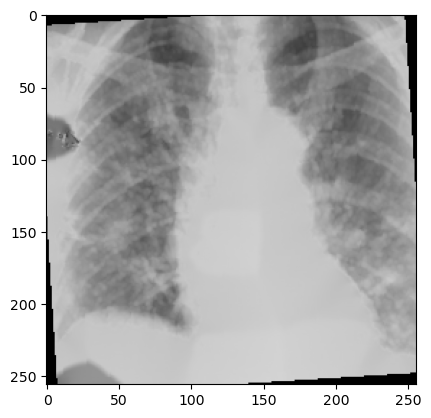

In [ ]:
img_fix = torch.permute(img[5],(1,2,0))
plt.imshow(img_fix)

In [ ]:
# Setting up the training step and testing step
def train_step(model, optimizer, loss_fn, epoch, dataloader):
  model.train()
  train_loss, acc = 0, 0
  total_correct = 0
  total_samples = 0

  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss +=loss.item()
    model.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    total_correct += (y_pred_class == y).sum().item()
    total_samples += y.size(0)

  acc = total_correct * 100 / total_samples

  train_loss = train_loss/len(dataloader)
  print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc:2f}")


def test_step(model, loss_fn, epoch, dataloader):
  model.eval()
  test_loss, acc = 0, 0
  total_correct = 0
  total_samples = 0


  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      total_correct += (y_pred_class == y).sum().item()
      total_samples += y.size(0)

    acc = total_correct * 100 / total_samples

    test_loss = test_loss/len(dataloader)
    print(f"Epoch: {epoch} | Test Loss: {loss} | Accuracy: {acc:2f}")
    print("************************")

In [ ]:
class ResNet_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet_Classifier, self).__init__()
        self.cnn = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, num_classes)

    def forward(self, x):
        return self.cnn(x)

In [ ]:
model = ResNet_Classifier(4).to(device)

Using cache found in C:\Users\shobh/.cache\torch\hub\pytorch_vision_v0.10.0
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model(img.to(device)).argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0,
        2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 3], device='cuda:0')

In [ ]:
# Setting up optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Training the model
epochs = 50
torch.manual_seed(42)
torch.cuda.manual_seed(42)
for epoch in range(epochs):
  train_step(model=model,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epoch=epoch,
             dataloader=train_dataloader)
  test_step(model=model,
            loss_fn=loss_fn,
            epoch=epoch,
            dataloader=test_dataloader)

Epoch: 0 | Loss: 0.09192507714033127 | Accuracy: 91.242491
Epoch: 0 | Test Loss: 6.415231227874756 | Accuracy: 5.447471
************************
Epoch: 1 | Loss: 0.1804438680410385 | Accuracy: 95.589630
Epoch: 1 | Test Loss: 0.8276235461235046 | Accuracy: 84.695201
************************
Epoch: 2 | Loss: 0.31914854049682617 | Accuracy: 95.273475
Epoch: 2 | Test Loss: 0.33754804730415344 | Accuracy: 91.699092
************************
Epoch: 3 | Loss: 0.007931051775813103 | Accuracy: 95.953209
Epoch: 3 | Test Loss: 1.2492899894714355 | Accuracy: 73.151751
************************
Epoch: 4 | Loss: 0.05287105217576027 | Accuracy: 96.648751
Epoch: 4 | Test Loss: 0.347414493560791 | Accuracy: 86.900130
************************


KeyboardInterrupt: 

In [ ]:
test_step(model=model,
        loss_fn=loss_fn,
        epoch=epoch,
        dataloader=val_dataloader)

Epoch: 5 | Test Loss: 0.912839412689209 | Accuracy: 65.789474
************************


In [ ]:
torch.save(obj=model.state_dict(),
           f=r"C:\Users\shobh\Desktop\python\chest_x_ray.pth")

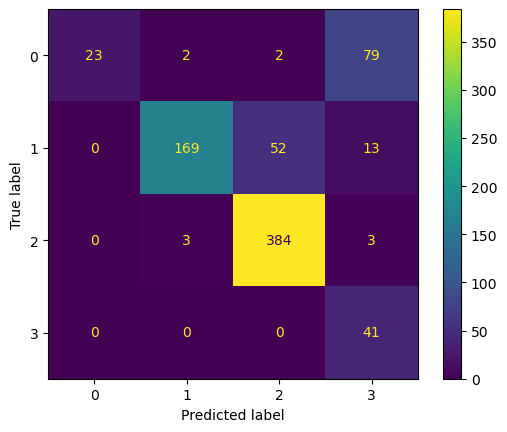

In [ ]:
# Plotting Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_true = []
y_preds = []

model.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)


    y_pred = model(X)
    y_pred_class = y_pred.argmax(dim=1)

    y_true.extend(y.cpu().numpy())
    y_preds.extend(y_pred_class.cpu().numpy())

cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(4))
disp.plot(cmap="viridis")  # Customize colormap if needed

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import argparse

class ResNet_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet_Classifier, self).__init__()
        self.cnn = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, num_classes)

    def forward(self, x):
        return self.cnn(x)

def inference(img_path, model_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img = Image.open(img_path).convert("RGB")
    img_tensor = ToTensor()(img).to(device)
    img_tensor = Resize((256,256))(img_tensor)

    model = ResNet_Classifier(4).to(device)
    model.load_state_dict(torch.load(f=model_path))
    model.eval()

    with torch.inference_mode():
        output = model(img_tensor.unsqueeze(0))

    ty = {0:"COVID19", 1:"NORMAL", 2:"PNEUMONIA", 3:"TURBERCULOSIS"}

    return ty[int(output.argmax(dim=1)[0])]

def parse_arg():
    parser = argparse.ArgumentParser(description="Chect X Ray Inference")

    parser.add_argument("--img", type=str, required=True, help='Input the path to the image')
    parser.add_argument("--model", type=str, default=r"C:\Users\shobh\Desktop\python\chest_x_ray.pth", help='Path to the model')

if __name__ == '__main__':
    args = parse_arg()
    output = inference(r"D:\chest_x_ray\train\NORMAL\IM-0115-0001.jpeg", r'C:\Users\shobh\Desktop\python\chest_x_ray.pth')

Using cache found in C:\Users\shobh/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\shobh\AppData\Local\Temp\ipykernel_25272\580160861.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

In [ ]:
model.load_state_dict(torch.load(r"D:\MedFlow\DeepDoor\chest_x_ray.pth"))

C:\Users\shobh\AppData\Local\Temp\ipykernel_13836\3055636965.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"D:\MedFlow\DeepDoor\chest

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), r"D:\MedFlow\DeepDoor\chest_x_ray.bin")